In [ ]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import sys 
from google.colab import drive 
import glob

path = "/content/drive" 
drive.mount(path, force_remount=True)  
data_path = "drive/MyDrive/dataset" 

myfiles = glob.glob(os.path.join(data_path, '*')) 
print(myfiles)


Mounted at /content/drive
['drive/MyDrive/dataset/training', 'drive/MyDrive/dataset/validation']


In [ ]:
class Dataset(object):
    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path)  , 'Insert a valid path!'

        # get class list
        self.data_classes = os.listdir(self.data_path)

        # init mapping dict
        self.data_mapping = {}

        # populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.endswith('.jpg'):
                    if c_name == 'distractor':
                        self.data_mapping[img_tmp] = -1
                    else:
                        self.data_mapping[img_tmp] = int(c_name)

        print('Loaded {:d} from {:s} images'.format(len(self.data_mapping.keys()),
                                                    self.data_path))

    def get_data_paths(self):
        # returns a list of imgpaths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.endswith('.jpg'):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)


    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)




#dataset folder with inside two folders: training and validation

validation_path = os.path.join(data_path, 'validation')
gallery_path = os.path.join(validation_path, 'gallery')
query_path = os.path.join(validation_path, 'query')
training_path = os.path.join(data_path, "training") 

training_dataset = Dataset(data_path = training_path)
gallery_dataset = Dataset(data_path=gallery_path)
query_dataset = Dataset(data_path=query_path)

# get training data and classes
training_paths, training_classes = training_dataset.get_data_paths()

# we get validation gallery and query data
gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
query_paths, query_classes = query_dataset.get_data_paths()


Loaded 697 from drive/MyDrive/dataset/training images
Loaded 534 from drive/MyDrive/dataset/validation/gallery images
Loaded 70 from drive/MyDrive/dataset/validation/query images


In [ ]:
#Convolutional Neural Network with 152 layers (uses identity connection to skip layers if needed)
model=ResNet50(weights='imagenet',
                          include_top=False, #to include the fully-connected layer at the top of the network; might try with True (delate input_shape if True)
                         input_shape=(224, 224, 3),
                        pooling='max') #global max pooling, may also try 'avg'

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#keras models:
#https://keras.io/api/applications/

#explaining features extracture with keras:
#https://franky07724-57962.medium.com/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1

In [ ]:
#DATA AUGMENTATION to expand the input dataset and perform modification to the imgages, such as rotations, zoom in, cuts…
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#keras command explanation: https://keras.io/api/preprocessing/image/
datagen = ImageDataGenerator(
    featurewise_center=False, #set input mean to zero if True
    samplewise_center=True, #set each sample mean to zero
    featurewise_std_normalization=False, #divide inputs by sd of the dataset
    samplewise_std_normalization=True, #divide each input by its sd 
    
    rotation_range=20, #degree range for random rotation
    width_shift_range=0.3, #range as a fraction of total width within which to randomly translate pictures vertically 
    height_shift_range=0.3, #ranges as a fraction of tot height within which to randomly translate pictures horizontally
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True, #randomly flip inputs horizontally
    vertical_flip=True, #randomly flip inputs vertically
    rescale=None, #all data are multiplied by specified value if given
    preprocessing_function=None, #after the img is resized and augmented (input must be np tensor with rank 3)
    data_format=None,
    validation_split=0.0, #between 0-1
    dtype=None, #for the generated arrays
)








'''
#flow_from_directory takes the path to a directory & generates batches of augmented data
aug_train_img_and_label = datagen.flow_from_directory(
    training_path,
    target_size=(224, 224), 
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset=None,
    interpolation="nearest",
)
'''
#basically modifies images 
#datagen.fit(training_paths) -> takes 3D array -> put into features_extraction function

'\n#flow_from_directory takes the path to a directory & generates batches of augmented data\naug_train_img_and_label = datagen.flow_from_directory(\n    training_path,\n    target_size=(224, 224), \n    color_mode="rgb",\n    classes=None,\n    class_mode="categorical",\n    batch_size=32,\n    shuffle=True,\n    seed=None,\n    save_to_dir=None,\n    save_prefix="",\n    save_format="png",\n    follow_links=False,\n    subset=None,\n    interpolation="nearest",\n)\n'

In [ ]:
def extract_features(training_paths, model):
    input_shape = (224, 224, 3) #this shape is standard in the karas models for neaural network
    nf=[]
    for n in range(len(training_paths)):
      img = image.load_img(training_paths[n],
                          target_size=(input_shape[0], input_shape[1]))
      img_array = image.img_to_array(img) #convert images in 3D arrays authomatically -> must use flatten() to push it into one dimension
      expanded_img_array = np.expand_dims(img_array, axis=0) #img_array has shape (None, 3) now; the first dimension need to be added through this command (tf)
      preprocessed_img = preprocess_input(expanded_img_array) #images are converted from RGB to BGR (tf)
       
     

      if n==1:
        print(preprocessed_img)
      
      
      i = 0
      for batch in datagen.flow(preprocessed_img, batch_size=16,
                          save_to_dir='drive/MyDrive/dataset/training/augmented',
                          save_prefix='aug',
                          save_format='png'):    
        i += 1    
        if i > 20:  #20 image ("epochs")      
          break

      if n==1:
        print(preprocessed_img)
      

      features = model.predict(preprocessed_img) #extract features from the images
      flattened_features = features.flatten() #collapse array into one dimension
      
      normalized_features = flattened_features / norm(flattened_features) #normalize
      nf.append(normalized_features)
    return nf

In [ ]:
feat = extract_features(training_paths, model) #this takes 7 mins to run :(

[[[[  24.060997    10.221001     5.3199997]
   [  20.060997    10.221001     7.3199997]
   [  21.060997     9.221001     6.3199997]
   ...
   [ 110.061      116.221      117.32     ]
   [ 119.061      116.221      127.32     ]
   [  72.061       69.221       79.32     ]]

  [[  28.060997    11.221001     9.32     ]
   [  26.060997    14.221001    11.32     ]
   [  24.060997    16.221        7.3199997]
   ...
   [ 111.061      120.221      124.32     ]
   [ 111.061      116.221      110.32     ]
   [ 118.061      124.221      122.32     ]]

  [[  85.061       79.221       91.32     ]
   [  62.060997    54.221       68.32     ]
   [  45.060997    29.221       44.32     ]
   ...
   [ 104.061      114.221      109.32     ]
   [ 111.061      117.221      115.32     ]
   [ 113.061      119.221      119.32     ]]

  ...

  [[ -74.939      -48.779     -117.68     ]
   [ -70.939      -40.779     -122.68     ]
   [ -70.939      -39.779     -123.68     ]
   ...
   [  17.060997    -4.7789993  -25.

In [ ]:
print(len(feat))
#%timeit feat = extract_features(training_paths, model)

697


In [ ]:
query_paths[:3]

['drive/MyDrive/dataset/validation/query/10/ec50k_00100006.jpg',
 'drive/MyDrive/dataset/validation/query/10/ec50k_00100015.jpg',
 'drive/MyDrive/dataset/validation/query/10/ec50k_00100026.jpg']

In [ ]:
#running this cell takes 5.31 mins

#normalized query features
query_features = extract_features(query_paths, model)

#normalized gallery features
gallery_features = extract_features(gallery_paths, model)


[[[[134.061      121.221      114.32      ]
   [133.061      120.221      113.32      ]
   [136.061      121.221      113.32      ]
   ...
   [-60.939003   -63.779      -76.68      ]
   [-41.939003   -49.779      -55.68      ]
   [-51.939003   -59.779      -65.68      ]]

  [[134.061      121.221      114.32      ]
   [134.061      121.221      114.32      ]
   [134.061      122.221      113.32      ]
   ...
   [-66.939      -77.779      -84.68      ]
   [-65.939      -71.779      -75.68      ]
   [-42.939003   -44.779      -53.68      ]]

  [[134.061      122.221      113.32      ]
   [134.061      121.221      114.32      ]
   [134.061      121.221      114.32      ]
   ...
   [-60.939003   -68.779      -72.68      ]
   [-69.939      -80.779      -77.68      ]
   [-66.939      -72.779      -76.68      ]]

  ...

  [[  1.060997    -1.7789993    1.3199997 ]
   [-10.939003   -18.779      -16.68      ]
   [-16.939003   -13.778999   -14.68      ]
   ...
   [-13.939003   -10.778999   -28.6

In [ ]:
print(feat[1], '\n', query_features[1])

[0.01268663 0.03560868 0.00432727 ... 0.         0.01809936 0.00509381] 
 [0.01924371 0.01562803 0.00839357 ... 0.04173271 0.01601842 0.0043832 ]


In [ ]:
def match_img(query_img_feat):
  distance = np.linalg.norm(gallery_features - query_img_feat, axis=1) #vectorial distance
  ids = np.argsort(distance)[:5]  #top 5 results
  scores = [(distance[id], gallery_paths[id]) for id in ids] #rank the results
  return (ids, scores)

In [ ]:
match_img(query_features[25])

(array([82, 80, 78, 76, 77]),
 [(0.5451745, 'drive/MyDrive/dataset/validation/gallery/2/ec50k_00020009.jpg'),
  (0.5518743, 'drive/MyDrive/dataset/validation/gallery/2/ec50k_00020006.jpg'),
  (0.5541407, 'drive/MyDrive/dataset/validation/gallery/2/ec50k_00020010.jpg'),
  (0.57228243,
   'drive/MyDrive/dataset/validation/gallery/2/ec50k_00020008.jpg'),
  (0.5747797,
   'drive/MyDrive/dataset/validation/gallery/2/ec50k_00020013.jpg')])

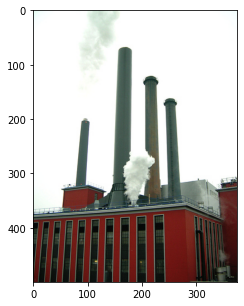

In [ ]:
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize = (5,5))
img = cv2.imread(query_paths[25])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#This image is matched with gallery/2, which is correct :)

TRY ANOTHER MODEL

In [ ]:
#Very Deep Convolutional Networks for Large-Scale Image Recognition
#16 layers deep

#explanation:
#https://medium.com/@nutanbhogendrasharma/deep-convolutional-networks-vgg16-for-image-recognition-in-keras-a4beb59f80a7


model = VGG16(weights='imagenet',
                      include_top=False, #to include the 3 fully-connected layers at the top of the network
                      input_shape=(224, 224, 3), 
                      pooling='max') #global max pooling, may also try 'avg'
#this model also works pretty well, it matches the imgs correctly, the accuracy/score is the same
#

58892288/58889256 [==============================] - 1s 0us/step


copied below the cells to run again when changing model:

In [ ]:
#trainig features
feat = extract_features(training_paths, model)

#normalized query features
query_features = extract_features(query_paths, model)

#normalized gallery features
gallery_features = extract_features(gallery_paths, model)

In [ ]:
match_img(query_features[40])

(array([518, 521, 511, 520, 515]),
 [(0.64937836,
   'drive/MyDrive/dataset/validation/gallery/18/ec50k_00180003.jpg'),
  (0.6765727,
   'drive/MyDrive/dataset/validation/gallery/18/ec50k_00180006.jpg'),
  (0.67765194,
   'drive/MyDrive/dataset/validation/gallery/18/ec50k_00180015.jpg'),
  (0.68266255,
   'drive/MyDrive/dataset/validation/gallery/18/ec50k_00180005.jpg'),
  (0.7046214,
   'drive/MyDrive/dataset/validation/gallery/18/ec50k_00180016.jpg')])

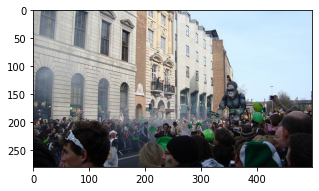

In [ ]:
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize = (5,5))
img = cv2.imread(query_paths[40])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
